In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

In [127]:
# get expressed genes w/o min tpm
df = pd.read_csv(ab, sep='\t')
df, tids = get_tpm_table(df,
               how='gene',
               min_tpm=0,
               gene_subset='protein_coding',
               groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for protein_coding genes
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of genes reported: 19289


In [129]:
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                    how='gene',
                    gene_subset='polya',
                    min_tpm=0,
                    groupby='sample',
                    ver=ver,
                    species='human')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of genes reported: 40815


In [121]:
# tpm bins
tpm_bins = [1, 10, 50, 100, df.values.max()]
# labels = ['Low (1-10)', 'Medium (10-100)', 'High (100-max)']
labels = ['1-10', '10-50', '50-100', '100-max']

In [122]:
df = df.melt(ignore_index=False).reset_index().rename({'value':'gene_tpm', 'index': 'gid'}, axis=1)

# pick the max. per gene
df.drop('biosample', axis=1, inplace=True)
df = df.groupby('gid').max().reset_index()

# group into bins
df['tpm_bin'] = pd.cut(df.gene_tpm, tpm_bins, labels=labels)
df['other_tpm_bin'] = pd.cut(df.gene_tpm, tpm_bins)
df.head()

,gid,gene_tpm,tpm_bin,other_tpm_bin
0,ENSG00000000003,878.796890,100-max,"(100.0, 87160.202]"
1,ENSG00000000005,13.381178,10-50,"(10.0, 50.0]"
2,ENSG00000000419,126.733157,100-max,"(100.0, 87160.202]"
3,ENSG00000000457,42.231929,10-50,"(10.0, 50.0]"
4,ENSG00000000460,99.069228,50-100,"(50.0, 100.0]"


In [123]:
# df.loc[df.gid=='ENSG00000000003']

In [124]:
# remove <1 TPM 
df = df.loc[df.tpm_bin.notnull()]

In [125]:
df

,gid,gene_tpm,tpm_bin,other_tpm_bin
0,ENSG00000000003,878.796890,100-max,"(100.0, 87160.202]"
1,ENSG00000000005,13.381178,10-50,"(10.0, 50.0]"
2,ENSG00000000419,126.733157,100-max,"(100.0, 87160.202]"
3,ENSG00000000457,42.231929,10-50,"(10.0, 50.0]"
4,ENSG00000000460,99.069228,50-100,"(50.0, 100.0]"
...,...,...,...,...
18728,ENSG00000285942,1.236758,1-10,"(1.0, 10.0]"
18729,ENSG00000285943,1.050246,1-10,"(1.0, 10.0]"
18731,ENSG00000285953,2.367895,1-10,"(1.0, 10.0]"
18732,ENSG00000285976,804.795841,100-max,"(100.0, 87160.202]"


In [13]:
# df['gid_sample'] = df['gid']+'_'+df['biosample']
# df.head()

100-max


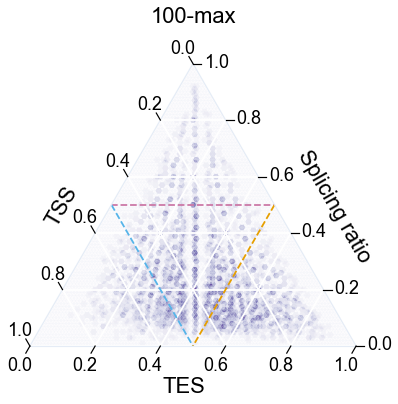

10-50


<Figure size 432x288 with 0 Axes>

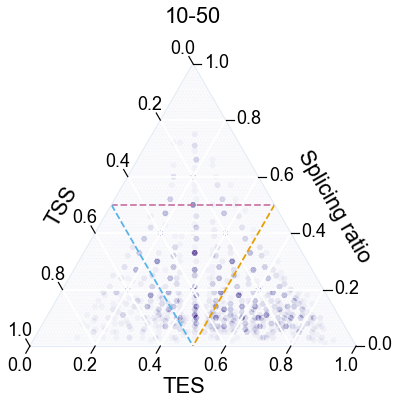

50-100


<Figure size 432x288 with 0 Axes>

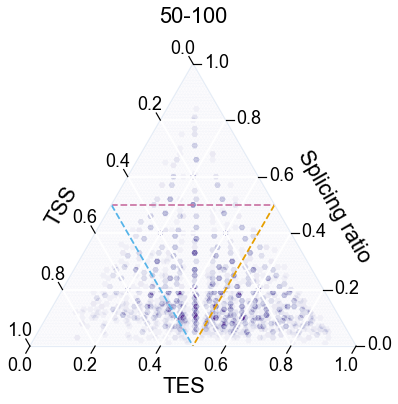

1-10


<Figure size 432x288 with 0 Axes>

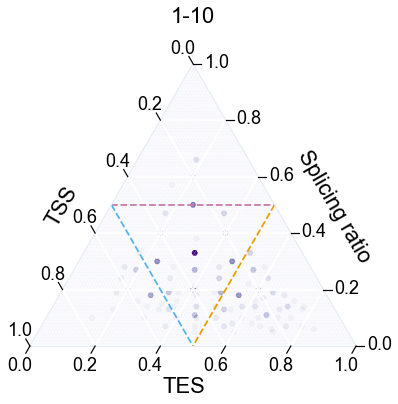

All


<Figure size 432x288 with 0 Axes>

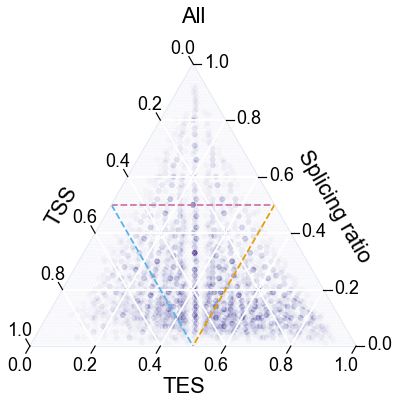

<Figure size 432x288 with 0 Axes>

In [14]:
# plot sector plot for each tpm bin
big_df = pd.DataFrame()
for b in df.tpm_bin.unique().tolist()+['All']:
    print(b)
    ca = cerberus.read(cerberus_h5)
    
    # limit to sample_det
    ca.triplets = ca.triplets.loc[ca.triplets.source=='obs_det']
    
    # get list of gid combos in this tpm bin
    if b != 'All':
        gids = df.loc[df.tpm_bin==b, 'gid'].tolist()
    
        # limit to just the sample + gene combinations that are in this tpm bin
        ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(gids)]
    
    # title fmting
    title = b
    
    temp = ca.plot_simplex(top='splicing_ratio',
        density=True,
        density_scale=100,
        density_cmap='Purples',
        log_density=True,
        sectors=True,
        scatter=False,
        legend=False,
        title=title,
        size_scale=0.6,
        density_cbar=False,
        fname=f'figures/ab_bin_sample_det_simplex_{b}.pdf')
    
    temp['tpm_bin'] = b
    big_df = pd.concat([big_df, temp], axis=0)

    plt.show()
    plt.clf()

In [15]:
big_df.to_csv('triplets_per_max_tpm_sector.tsv', sep='\t')

In [5]:
big_df = pd.read_csv('triplets_per_max_tpm_sector.tsv', sep='\t')
big_df.head()

,Unnamed: 0,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,tpm_bin
0,0,obs_det,ENSG00000000003,1.0,6.0,9.0,29.0,2.571429,10.447761,62.686567,26.865672,tes,TSPAN6,NaN,NaN,100-max
1,2,obs_det,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,24.390244,36.585366,39.024390,mixed,DPM1,NaN,NaN,100-max
2,5,obs_det,ENSG00000000938,5.0,4.0,16.0,20.0,3.555556,39.823009,31.858407,28.318584,mixed,FGR,NaN,NaN,100-max
3,6,obs_det,ENSG00000000971,2.0,5.0,9.0,9.0,2.571429,20.895522,52.238806,26.865672,tes,CFH,NaN,NaN,100-max
4,7,obs_det,ENSG00000001036,2.0,5.0,9.0,9.0,2.571429,20.895522,52.238806,26.865672,tes,FUCA2,NaN,NaN,100-max


In [6]:
big_df[['gid', 'tpm_bin']].groupby('tpm_bin').nunique()


,gid
tpm_bin,
1-10,1457
10-50,3899
100-max,8481
50-100,3299
All,26544


In [114]:
def make_sector_source_bar_plots(counts, fname):
    temp = counts[['gid', 'tpm_bin']].groupby('tpm_bin').count().reset_index().rename({'gid':'total_genes'}, axis=1)
    # temp = pd.DataFrame()
    # for source in counts.source.unique():
    #     df = assign_gisx_sector(counts)
    #     df = df.loc[df.source == source]
    #     df = df[['gid', 'tpm_bin', 'sector']].groupby(['tpm_bin', 'sector']).count().reset_index()
    #     df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
    #     df['total_genes'] = df.n_genes.sum()
    #     temp = pd.concat([temp, df])
    temp2 = counts[['gid', 'tpm_bin', 'sector']].groupby(['tpm_bin', 'sector']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
    temp = temp.merge(temp2, how='left', on='tpm_bin')
    temp['perc'] = (temp.n_genes/temp.total_genes)*100

    cat1 = 'sector'
    cat2 = 'tpm_bin'
    # cat2 = 'source'
    # if species == 'human':
    #     cat2_order = ['v40', 'obs_det', 'obs_major']
    # elif species == 'mouse':
    #     cat2_order = ['vM25', 'obs_det', 'obs_major']?
    cat1_order = ['tss', 'splicing', 'tes', 'mixed', 'simple']
    # cat2_order = ['Low (1-10)', 'Medium (10-100)', 'High (100-max)', 'All']
    cat2_order = ['1-10', '10-50', '50-100', '100-max']
    parent_c_dict, parent_order = get_sector_colors()

    sns.set_context('paper', font_scale=2)
    plt.figure(figsize=(2,20))
    fig, axes = plt.subplots(1, len(cat1_order), figsize=(24,3))
    fig.subplots_adjust(hspace=0.0)
    fig.subplots_adjust(wspace=0.3)
    

    # loop through first category
    for i, c1 in enumerate(cat1_order):
        beep = temp.loc[temp[cat1] == c1]

        c = parent_c_dict[c1]
        c_dict, order = get_shade_colors(c, cat2_order)

        # plotting
        mpl.rcParams['font.family'] = 'Arial'
        mpl.rcParams['pdf.fonttype'] = 42
        # plt.figure(figsize=(3,4))
        ax = sns.barplot(data=beep, y='perc', x=cat2,
                         palette=c_dict, order=order,
                         saturation=1, ax=axes[i])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        xlabel = ''
        if c1 in ['tss', 'tes']:
            c1 = c1.upper()
        ylabel = '% genes in {} sector'.format(c1)

        _ = ax.set(xlabel=xlabel, ylabel=ylabel)
        ax.tick_params(axis="x", rotation=45)
        # if species == 'human':
        #     ax.set_xticklabels(['v40', 'Obs.', 'Obs. major'])
        # elif species == 'mouse':
        #     ax.set_xticklabels(['vM25', 'Obs.', 'Obs. major'])

        def add_perc_2(ax):
            ylim = ax.get_ylim()[1]
            n_cats = len(ax.patches)
            for p in ax.patches:
                percentage = '{:.1f}%'.format(p.get_height())
                x = p.get_x() + p.get_width() / 2
                y = p.get_y() + p.get_height() + ylim*0.01
                ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

        add_perc_2(ax)
    plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


<Figure size 144x1440 with 0 Axes>

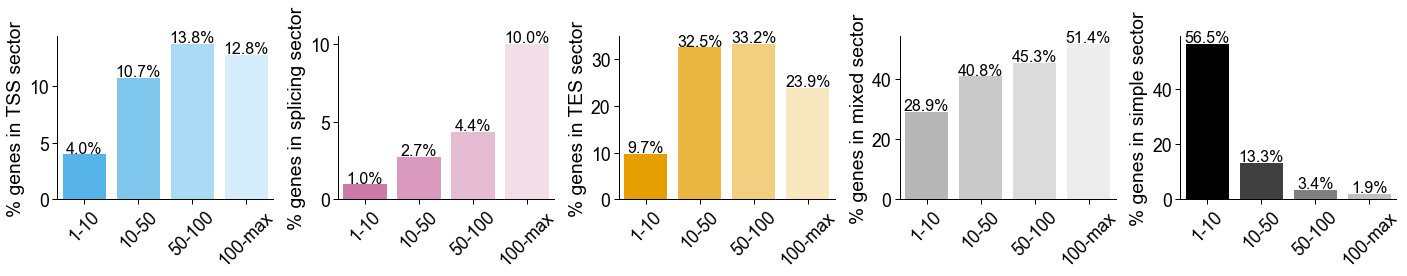

In [115]:
make_sector_source_bar_plots(big_df, 'figures/diversity_by_gene_tpm.pdf')

## GO terms per TPM bin

In [4]:
big_df = pd.read_csv('triplets_per_max_tpm_sector.tsv', sep='\t')

In [7]:
def do_go_thing(df):
    dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human',
          'Pfam_Domains_2019']
    # bm = gp.parser.Biomart()
    # datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    # datasets.loc[datasets.Description.str.contains('Human')]
    
    for s in df.tpm_bin.unique():
        print(s)
        desc = '{} genes'.format(s)
        odir = f'go/{s}_genes_GO'
        # gids = df.loc[df.sector == s, 'gid'].tolist()
        # gids = bm.query(dataset='hsapiens_gene_ensembl',
        #        attributes=['ensembl_gene_id', 'external_gene_name'],
        #        filters={'ensembl_gene_id': gids})
        # gids = gids.loc[~gids.external_gene_name.isna()]
        # gnames = gids.external_gene_name.squeeze().str.strip().tolist()
        gnames = df.loc[df.tpm_bin==s, 'gname'].tolist()
        go = gp.enrichr(gene_list=gnames,
                        gene_sets=dbs,
                        organism='Human',
                        description=desc,
                        outdir=odir,
                        cutoff=0.5)

In [13]:
# do_go_thing(big_df)

In [10]:
def rm_go_number(df):
    df['term'] = df['Term'].str.split('\(GO', expand=True)[0]
    return df

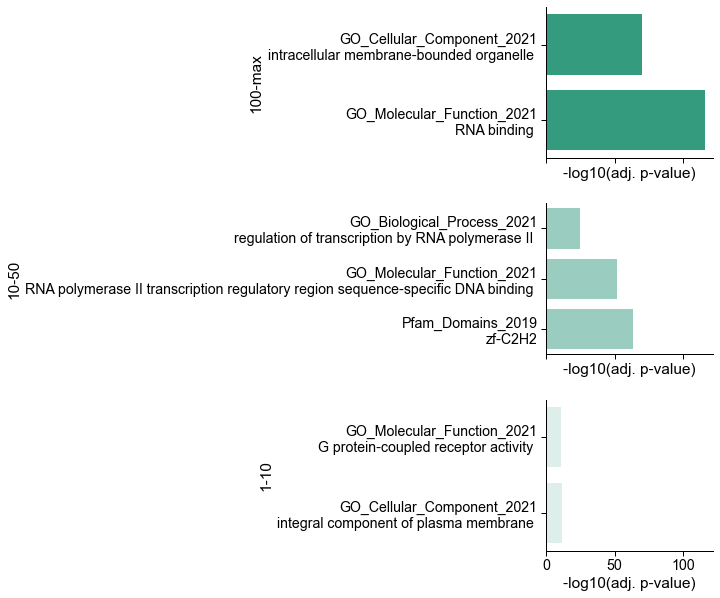

In [106]:
# make a plot w/ signficance of selected go terms

sns.set_context('paper', font_scale=1.6)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

df = pd.DataFrame()

# 1-10 molecular function - gpcr activity
temp = pd.read_csv('go/1-10_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
temp = rm_go_number(temp)
temp = temp.iloc[[0]]
temp['tpm_bin'] = '1-10'
df = pd.concat([df, temp], axis=0)

# 1-10 cellular component - plasma membrane
temp = pd.read_csv('go/1-10_genes_GO/GO_Cellular_Component_2021.Human.enrichr.reports.txt', sep='\t')
temp = rm_go_number(temp)
temp = temp.iloc[[0]]
temp['tpm_bin'] = '1-10'
df = pd.concat([df, temp], axis=0)

# 10-50 pfam domains - zfC2H2
temp = pd.read_csv('go/10-50_genes_GO/Pfam_Domains_2019.Human.enrichr.reports.txt', sep='\t')
temp = rm_go_number(temp)
temp = temp.iloc[[0]]
temp['tpm_bin'] = '10-50'
df = pd.concat([df, temp], axis=0)

# 10-50 molecular function domains - DNA binding
temp = pd.read_csv('go/10-50_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
temp = rm_go_number(temp)
temp = temp.iloc[[0]]
temp['tpm_bin'] = '10-50'
df = pd.concat([df, temp], axis=0)

# 10-50 biological process - transcription
temp = pd.read_csv('go/10-50_genes_GO/GO_Biological_Process_2021.Human.enrichr.reports.txt', sep='\t')
temp = rm_go_number(temp)
temp = temp.iloc[[0]]
temp['tpm_bin'] = '10-50'
df = pd.concat([df, temp], axis=0)

# 100-max cellular component - RNA binding
temp = pd.read_csv('go/100-max_genes_GO/GO_Cellular_Component_2021.Human.enrichr.reports.txt', sep='\t')
temp = rm_go_number(temp)
temp = temp.iloc[[0]]
temp['tpm_bin'] = '100-max'
df = pd.concat([df, temp], axis=0)

# 100-max molecular function - RNA binding
temp = pd.read_csv('go/100-max_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
temp = rm_go_number(temp)
temp = temp.iloc[[0]]
temp['tpm_bin'] = '100-max'
df = pd.concat([df, temp], axis=0)

df.head()

# df['bin_go_cat'] = df.tpm_bin+' '+df.term+'\n'+df['Gene_set']
# ax = sns.barplot(df, x='-log10(adj. p-value)', y='bin_go_cat')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# ax.set(ylabel='')
# ax.tick_params(axis="x", rotation=45)

ic_colors, order = get_ic_nov_colors()
gray = get_not_det_color()
c = ic_colors['Known']
cats = df.tpm_bin.tolist()[::-1]
c_dict, order = get_shade_colors(c, cats)

df['-log10(adj. p-value)'] = -1*np.log10(df['Adjusted P-value'])
df['go'] = df['Gene_set']+'\n'+df.term
df = df.sort_values(by='-log10(adj. p-value)', ascending=True)
# plt.figure(figsize=(3,4))
fig, axs = plt.subplots(3,1, frameon=False, figsize=(3,10), sharex=True)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.00)
for b, ax in zip(df.tpm_bin.unique()[::-1], axs):
    temp = df.loc[df.tpm_bin==b].copy(deep=True)
    sns.barplot(temp, x='-log10(adj. p-value)', y='go', ax=ax, color=c_dict[b])
    ax.set(ylabel=b)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.tick_params(axis="x", rotation=90)
df.head()

plt.savefig('figures/go_terms_per_gene_tpm_bin.pdf', dpi=500)

In [21]:
df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,term,-log10(adj. p-value)
0,GO_Molecular_Function_2021,G protein-coupled receptor activity (GO:0004930),61/283,1.031260e-14,5.661615e-12,0,0,3.606124,116.136693,GPR26;PTGDR2;MLNR;RXFP4;GPR20;GPR61;ADRA1B;RXF...,G protein-coupled receptor activity,11.24706
